In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *

np.random.seed(seed=7)

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

This conv2d network is more inspired from a classic conv2d net that is used for image recognition 

In [3]:
from models import *

In [4]:
def compute_nb_errors(model, data_input, data_target, batch_size):
    nb_errors = 0
    Ndata = len(data_input[:, 0, 0, 0])
    model.eval()
    print('data_target', data_target.shape)
    print('data_input', data_input.shape)
    
    for b_start in range(0, Ndata, batch_size):
        bsize_eff = batch_size - max(0, b_start+batch_size-Ndata)  # boundary case
        batch_output = model.forward(data_input.narrow(0, b_start, bsize_eff))  # is Variable if data_input is Variable
        if len(list(batch_output.size()))>1 and batch_output.size(1) > 1:
            # as many ouputs as there are classes => select maximum output
            nb_err_batch = (batch_output.max(1)[1] != data_target.narrow(0, b_start, bsize_eff)).long().sum()
            # overflow problem if conversion to Long Int not performed, treated as short 1-byte int otherwise!!
        else:
            # output is a scalar in [0, 1]
            nb_err_batch = batch_output.round().sub(data_target.narrow(0, b_start, bsize_eff)).sign().abs().sum()
        
        nb_errors += nb_err_batch
    if isinstance(nb_errors, Variable):
        nb_errors = nb_errors.data[0]
    return nb_errors

# Preprocessing and Data Augmentation

In [5]:
import numpy as np

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target, kept_channels_idx = preprocessing_train(train_input_1000, train_target_1000, subsampling_frequency='125Hz', window=False,denoize=False, addGaussianNoise=False, reduceChannels=False, cutEnd = False)
preprocessed_input_test, preprocessed_input_test_target  = preprocessing_test(test_input_1000, test_target_1000, kept_channels_idx, subsampling_frequency='125Hz', window=False,denoize = False, reduceChannels=False, cutEnd=False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = torch.from_numpy(preprocessed_input_test_target)
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

Nchannels = len(preprocessed_input_train[0,:,0])
Nsamples_100 = preprocessed_input_train.size(-1)

print('Ntrain = ', Ntrain)
print('Ntest = ', Ntest)
print('Nvalidation = ', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, Nchannels, Nsamples_100))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, Nchannels, Nsamples_100), requires_grad=False)
test_input = Variable(preprocessed_input_test.contiguous().view(Ntest, 1, Nchannels, Nsamples_100), requires_grad=False)

train (2400, 28, 62)
test (800, 28, 62)
validation (128, 28, 62)
Ntrain =  2400
Ntest =  800
Nvalidation =  128


# Network training and testing
Non-linearity: elu  


|criterion | optimizer | lr  | momentum | batch size | Nepochs | Train acc. | Test acc.|
|----------|-----------|-----|----------|------------|---------|------------|----------|
| BCE  | Adam  |1e-1 | def. | 15 | 150 | 86.4 | 61.4 | 
| BCE  | Adam  |1e-1 | def. | 20 | 150 | 99.8 | 79.5 | 
| BCE  | SGD   | 1e-2 | 0.85 | 20 | 150 | 98.9  | 61.5 | 
| CE   | Adam  | 1e-2 | def. | 20 | 150 | 98.4  |  70.5 | 
| CE   | SGD   | 1e-2 | 0.85 | 20 | 150 | 99.1 | 75.1 |


Non-linearity: ReLU

In [6]:
import torch.optim as optim
import math

# Train network 
#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False)
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False )
    Noutputs = 2
    
else:
    train_target = Variable(labels_train.float()) # convert to float
    validation_target = Variable(labels_validation.float(), requires_grad=False) # convert to float
    test_target = Variable(labels_test.float(), requires_grad=False)
    Noutputs = 1

batch_size = 15
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 50
seeds = list(range(14, 29))
#seeds = [14,20,21,22,27,46,44,37,31,28]
Nrep = len(seeds)

train_errors = torch.Tensor(Nrep, Nepochs).zero_()
test_errors = torch.Tensor(Nrep, Nepochs).zero_()
validation_errors = torch.Tensor(Nrep, Nepochs).zero_()
ep_loss = torch.Tensor(Nrep, Nepochs).zero_()

for i_rep in range(Nrep):    
    print('Repetition', seeds[i_rep])
    torch.manual_seed(seeds[i_rep])
    #model = conv2DNet_1(Noutputs) #from classic knowledge of image segmentation  
    model = conv2DNet_2(Nchannels, Nsamples_100, Noutputs) #from litterature 
    #model = conv2DNet_3(Noutputs) #from PdM
    #model = conv2DNet_4(Noutputs) #from PdM
    #model = conv2DNet_5(Noutputs) #from PdM
    #model = conv2DNet_6(Noutputs)
    
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.50)
    #optimizer = optim.Adam(model.parameters())
    #optimizer = optim.Adagrad(model.parameters())
    #optimizer = optim.Adamax(model.parameters())
    #optimizer = optim.ASGD(model.parameters())
    #optimizer = optim.RMSprop(model.parameters())
    #optimizer = optim.Rprop(model.parameters())
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output, train_target.narrow(0, b_start, bsize_eff))            
            ep_loss[i_rep, i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_rep, i_ep])
        
        nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size)
        nb_test_errs = compute_nb_errors(model, test_input, test_target, batch_size)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) 
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_rep, i_ep])
        
        train_errors[i_rep, i_ep] = nb_train_errs
        test_errors[i_rep, i_ep] = nb_test_errs
        validation_errors[i_rep, i_ep] = nb_validation_errs

Repetition 14
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  0
	 Training accuracy:  51.666666666666664
	 Validation accuracy  58.59375
	 Test accuracy  47.125
	 Epoch Loss  111.24918365478516
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  1
	 Training accuracy:  56.666666666666664
	 Validation accuracy  57.03125
	 Test accuracy  45.375
	 Epoch Loss  110.4078369140625
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  2
	 Training accuracy:  58.5
	 Validati

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  23
	 Training accuracy:  60.916666666666664
	 Validation accuracy  64.84375
	 Test accuracy  54.25
	 Epoch Loss  100.589599609375
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  24
	 Training accuracy:  63.125
	 Validation accuracy  60.9375
	 Test accuracy  55.25
	 Epoch Loss  99.60166931152344
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  25
	 Training accuracy:  63.083333333333336
	 Validation accuracy  59.375
	 Test accuracy  54.875
	 Epoch Loss  98.44535827636719
data_targe

Epoch Number :  46
	 Training accuracy:  82.91666666666667
	 Validation accuracy  76.5625
	 Test accuracy  66.375
	 Epoch Loss  74.15496063232422
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  47
	 Training accuracy:  83.08333333333333
	 Validation accuracy  77.34375
	 Test accuracy  66.375
	 Epoch Loss  73.37979125976562
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  48
	 Training accuracy:  82.83333333333333
	 Validation accuracy  75.0
	 Test accuracy  69.875
	 Epoch Loss  72.41919708251953
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62]

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  20
	 Training accuracy:  66.875
	 Validation accuracy  41.40625
	 Test accuracy  46.375
	 Epoch Loss  105.63519287109375
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  21
	 Training accuracy:  66.83333333333333
	 Validation accuracy  41.40625
	 Test accuracy  46.125
	 Epoch Loss  105.3028335571289
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  22
	 Training accuracy:  66.70833333333333
	 Validation accuracy

Epoch Number :  43
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  94.90737915039062
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  44
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  94.3465805053711
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  45
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  93.78643798828125
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  17
	 Training accuracy:  63.291666666666664
	 Validation accuracy  51.5625
	 Test accuracy  43.25
	 Epoch Loss  103.18150329589844
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  18
	 Training accuracy:  63.625
	 Validation accuracy  52.34375
	 Test accuracy  43.625
	 Epoch Loss  102.63200378417969
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  19
	 Training accuracy:  64.04166666666667
	 Validation accuracy  52.34375
	 Test accuracy  43.25
	 Epoch Loss  102.1702651977539
data_t

Epoch Number :  40
	 Training accuracy:  76.0
	 Validation accuracy  40.625
	 Test accuracy  44.0
	 Epoch Loss  87.12853240966797
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  41
	 Training accuracy:  76.58333333333333
	 Validation accuracy  39.0625
	 Test accuracy  44.625
	 Epoch Loss  86.06211853027344
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  42
	 Training accuracy:  77.0
	 Validation accuracy  39.84375
	 Test accuracy  45.875
	 Epoch Loss  84.7804183959961
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([8

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  14
	 Training accuracy:  61.666666666666664
	 Validation accuracy  40.625
	 Test accuracy  46.375
	 Epoch Loss  108.22267150878906
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  15
	 Training accuracy:  61.25
	 Validation accuracy  39.84375
	 Test accuracy  46.375
	 Epoch Loss  107.99642181396484
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  16
	 Training accuracy:  61.25
	 Validation accuracy  40.625
	 Te

Epoch Number :  37
	 Training accuracy:  66.95833333333333
	 Validation accuracy  43.75
	 Test accuracy  51.25
	 Epoch Loss  99.75146484375
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  38
	 Training accuracy:  66.75
	 Validation accuracy  43.75
	 Test accuracy  50.625
	 Epoch Loss  99.1272201538086
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  39
	 Training accuracy:  66.83333333333333
	 Validation accuracy  46.09375
	 Test accuracy  50.0
	 Epoch Loss  98.48661804199219
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  11
	 Training accuracy:  64.0
	 Validation accuracy  60.15625
	 Test accuracy  45.75
	 Epoch Loss  107.4532699584961
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  12
	 Training accuracy:  64.66666666666667
	 Validation accuracy  61.71875
	 Test accuracy  45.625
	 Epoch Loss  107.06739044189453
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  13
	 Training accuracy:  65.0
	 Validation accuracy  62.5
	 Test ac

Epoch Number :  34
	 Training accuracy:  78.08333333333333
	 Validation accuracy  74.21875
	 Test accuracy  56.875
	 Epoch Loss  90.62938690185547
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  35
	 Training accuracy:  78.79166666666667
	 Validation accuracy  74.21875
	 Test accuracy  57.875
	 Epoch Loss  89.6037368774414
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  36
	 Training accuracy:  79.41666666666667
	 Validation accuracy  75.0
	 Test accuracy  59.875
	 Epoch Loss  88.51616668701172
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62]

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  8
	 Training accuracy:  61.083333333333336
	 Validation accuracy  39.84375
	 Test accuracy  47.625
	 Epoch Loss  109.61895751953125
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  9
	 Training accuracy:  60.833333333333336
	 Validation accuracy  39.84375
	 Test accuracy  47.625
	 Epoch Loss  109.49058532714844
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  10
	 Training accuracy:  60.708333333333336
	 Valida

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  31
	 Training accuracy:  68.91666666666667
	 Validation accuracy  43.75
	 Test accuracy  54.5
	 Epoch Loss  102.8616714477539
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  32
	 Training accuracy:  69.08333333333333
	 Validation accuracy  43.75
	 Test accuracy  55.25
	 Epoch Loss  102.198486328125
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  33
	 Training accuracy:  69.58333333333333
	 Validation accuracy  43.75
	 Test accuracy  56.125
	 Epoch Loss  101.49030303955078
data_ta

Epoch Number :  4
	 Training accuracy:  52.75
	 Validation accuracy  42.96875
	 Test accuracy  50.375
	 Epoch Loss  109.6334228515625
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  5
	 Training accuracy:  54.25
	 Validation accuracy  42.96875
	 Test accuracy  50.875
	 Epoch Loss  109.36650848388672
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  6
	 Training accuracy:  55.625
	 Validation accuracy  42.96875
	 Test accuracy  51.0
	 Epoch Loss  109.09539794921875
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
d

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  28
	 Training accuracy:  69.54166666666667
	 Validation accuracy  53.125
	 Test accuracy  56.25
	 Epoch Loss  99.4119873046875
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  29
	 Training accuracy:  70.45833333333333
	 Validation accuracy  58.59375
	 Test accuracy  56.25
	 Epoch Loss  98.74209594726562
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  30
	 Training accuracy:  71.875
	 Validation accuracy  61.7

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  1
	 Training accuracy:  56.5
	 Validation accuracy  34.375
	 Test accuracy  45.0
	 Epoch Loss  110.2140884399414
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  2
	 Training accuracy:  56.375
	 Validation accuracy  35.15625
	 Test accuracy  44.75
	 Epoch Loss  110.04611206054688
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  3
	 Training accuracy:  57.083333333333336
	 Validation accuracy  35.15625
	 Test accuracy  44.375
	 Epoch Loss  109.9073715209961
data_target torch.Size([2

Epoch Number :  24
	 Training accuracy:  64.91666666666667
	 Validation accuracy  44.53125
	 Test accuracy  47.875
	 Epoch Loss  105.31346893310547
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  25
	 Training accuracy:  65.66666666666667
	 Validation accuracy  45.3125
	 Test accuracy  50.125
	 Epoch Loss  104.89801025390625
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  26
	 Training accuracy:  66.29166666666667
	 Validation accuracy  44.53125
	 Test accuracy  49.625
	 Epoch Loss  104.43681335449219
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  48
	 Training accuracy:  83.875
	 Validation accuracy  69.53125
	 Test accuracy  64.25
	 Epoch Loss  81.35810852050781
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  49
	 Training accuracy:  84.75
	 Validation accuracy  71.09375
	 Test accuracy  64.5
	 Epoch Loss  80.1107177734375
Repetition 22
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  0
	 Training accuracy:  50.541666666666664
	 Validation accuracy  5

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  21
	 Training accuracy:  57.333333333333336
	 Validation accuracy  59.375
	 Test accuracy  44.375
	 Epoch Loss  107.74364471435547
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  22
	 Training accuracy:  57.833333333333336
	 Validation accuracy  60.9375
	 Test accuracy  43.625
	 Epoch Loss  107.52045440673828
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  23
	 Training accuracy:  58.708333333333336
	 Validation accuracy  60.9375
	 Test accuracy  42.75
	 Epoch Loss  107.293502807

Epoch Number :  44
	 Training accuracy:  67.33333333333333
	 Validation accuracy  55.46875
	 Test accuracy  46.125
	 Epoch Loss  100.02007293701172
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  45
	 Training accuracy:  67.41666666666667
	 Validation accuracy  56.25
	 Test accuracy  46.125
	 Epoch Loss  99.58026885986328
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  46
	 Training accuracy:  68.625
	 Validation accuracy  52.34375
	 Test accuracy  46.125
	 Epoch Loss  99.06929016113281
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_t

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  18
	 Training accuracy:  82.45833333333333
	 Validation accuracy  75.0
	 Test accuracy  69.75
	 Epoch Loss  84.42017364501953
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  19
	 Training accuracy:  83.125
	 Validation accuracy  75.78125
	 Test accuracy  70.125
	 Epoch Loss  83.02193450927734
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  20
	 Training accuracy:  84.04166666666667
	 Validation accuracy  78.1

Epoch Number :  41
	 Training accuracy:  90.83333333333333
	 Validation accuracy  78.125
	 Test accuracy  71.375
	 Epoch Loss  65.33989715576172
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  42
	 Training accuracy:  91.04166666666667
	 Validation accuracy  78.90625
	 Test accuracy  70.75
	 Epoch Loss  64.90624237060547
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  43
	 Training accuracy:  91.16666666666667
	 Validation accuracy  78.125
	 Test accuracy  71.25
	 Epoch Loss  64.47843170166016
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  15
	 Training accuracy:  59.666666666666664
	 Validation accuracy  21.875
	 Test accuracy  52.625
	 Epoch Loss  108.80689239501953
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  16
	 Training accuracy:  59.875
	 Validation accuracy  21.09375
	 Test accuracy  53.375
	 Epoch Loss  108.63664245605469
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  17
	 Training accuracy:  60.125
	 Validation accuracy  21.875
	 

Epoch Number :  38
	 Training accuracy:  69.33333333333333
	 Validation accuracy  37.5
	 Test accuracy  50.875
	 Epoch Loss  101.60392761230469
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  39
	 Training accuracy:  70.08333333333333
	 Validation accuracy  38.28125
	 Test accuracy  50.75
	 Epoch Loss  101.04681396484375
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  40
	 Training accuracy:  70.70833333333333
	 Validation accuracy  38.28125
	 Test accuracy  51.25
	 Epoch Loss  100.42179107666016
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 6

Epoch Number :  11
	 Training accuracy:  57.125
	 Validation accuracy  39.0625
	 Test accuracy  44.375
	 Epoch Loss  107.9620132446289
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  12
	 Training accuracy:  58.291666666666664
	 Validation accuracy  34.375
	 Test accuracy  45.625
	 Epoch Loss  107.66659545898438
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  13
	 Training accuracy:  58.916666666666664
	 Validation accuracy  32.03125
	 Test accuracy  46.5
	 Epoch Loss  107.3406753540039
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_t

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  35
	 Training accuracy:  66.58333333333333
	 Validation accuracy  38.28125
	 Test accuracy  51.25
	 Epoch Loss  97.3865737915039
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  36
	 Training accuracy:  66.70833333333333
	 Validation accuracy  35.9375
	 Test accuracy  51.25
	 Epoch Loss  96.75592803955078
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  37
	 Training accuracy:  67.41666666666667
	 Validation ac

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  8
	 Training accuracy:  60.25
	 Validation accuracy  48.4375
	 Test accuracy  46.625
	 Epoch Loss  108.3493423461914
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  9
	 Training accuracy:  60.833333333333336
	 Validation accuracy  50.78125
	 Test accuracy  46.75
	 Epoch Loss  108.07913208007812
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  10
	 Training accuracy:  61.416666666666664
	 Validation accuracy  51.5625
	 Test accuracy  46.625
	 Epoch Loss  107.80282592773438
data_tar

Epoch Number :  31
	 Training accuracy:  75.5
	 Validation accuracy  56.25
	 Test accuracy  58.125
	 Epoch Loss  90.32000732421875
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  32
	 Training accuracy:  76.375
	 Validation accuracy  53.90625
	 Test accuracy  59.0
	 Epoch Loss  89.07106018066406
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  33
	 Training accuracy:  77.125
	 Validation accuracy  51.5625
	 Test accuracy  59.75
	 Epoch Loss  87.82569122314453
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  5
	 Training accuracy:  56.041666666666664
	 Validation accuracy  42.96875
	 Test accuracy  46.25
	 Epoch Loss  109.16057586669922
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  6
	 Training accuracy:  57.083333333333336
	 Validation accuracy  43.75
	 Test accuracy  46.25
	 Epoch Loss  108.85997009277344
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  7
	 Training accuracy:  57.666666666666664
	 Validation a

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  28
	 Training accuracy:  68.75
	 Validation accuracy  42.1875
	 Test accuracy  45.25
	 Epoch Loss  96.53521728515625
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  29
	 Training accuracy:  68.375
	 Validation accuracy  43.75
	 Test accuracy  44.25
	 Epoch Loss  95.88770294189453
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  30
	 Training accuracy:  68.75
	 Validation accuracy  40.625
	 Test accuracy  45.875
	 Epoch Loss  95.22402954101562
data_target torch.Size([2400])
data_in

Epoch Number :  1
	 Training accuracy:  53.791666666666664
	 Validation accuracy  66.40625
	 Test accuracy  52.0
	 Epoch Loss  110.6987533569336
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  2
	 Training accuracy:  55.875
	 Validation accuracy  67.1875
	 Test accuracy  48.625
	 Epoch Loss  110.10956573486328
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  3
	 Training accuracy:  58.333333333333336
	 Validation accuracy  57.8125
	 Test accuracy  47.875
	 Epoch Loss  109.64424133300781
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_ta

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  25
	 Training accuracy:  69.66666666666667
	 Validation accuracy  47.65625
	 Test accuracy  47.0
	 Epoch Loss  100.09671783447266
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  26
	 Training accuracy:  69.79166666666667
	 Validation accuracy  49.21875
	 Test accuracy  48.0
	 Epoch Loss  99.42010498046875
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  27
	 Training accuracy:  70.41666666666667
	 Validation a

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  48
	 Training accuracy:  80.58333333333333
	 Validation accuracy  64.0625
	 Test accuracy  57.25
	 Epoch Loss  81.09937286376953
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  49
	 Training accuracy:  81.125
	 Validation accuracy  64.0625
	 Test accuracy  57.875
	 Epoch Loss  80.28946685791016


torch.Size([15, 50])
0


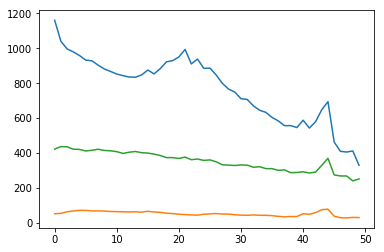

1


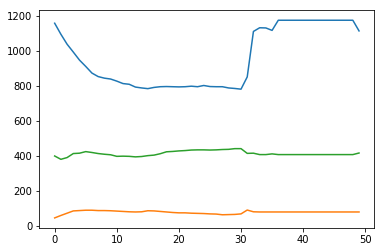

2


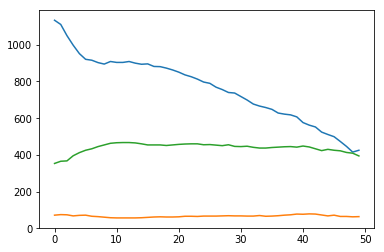

3


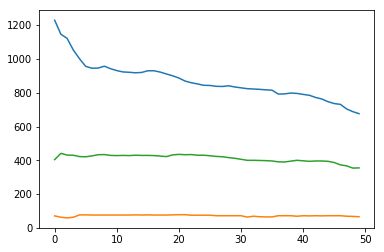

4


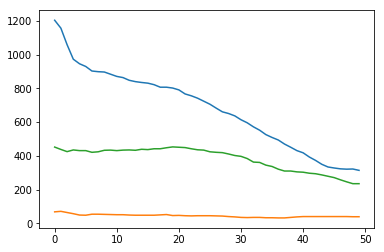

5


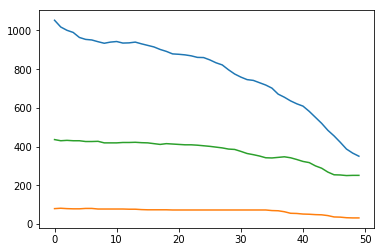

6


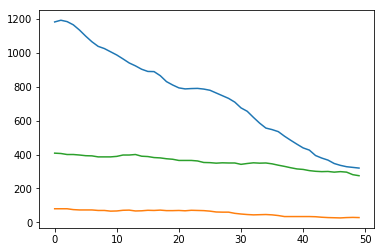

7


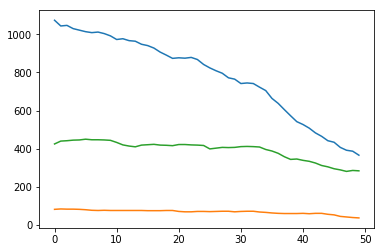

8


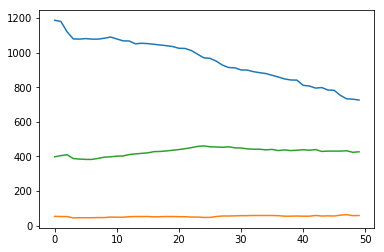

9


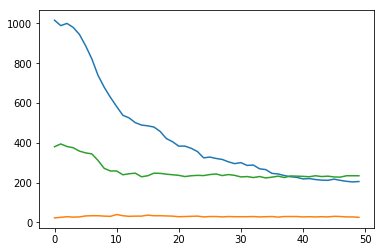

10


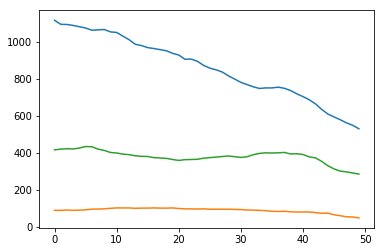

11


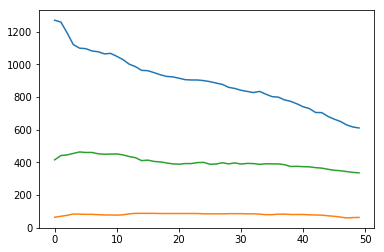

12


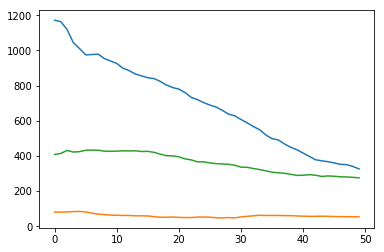

13


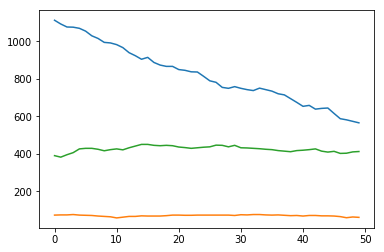

14


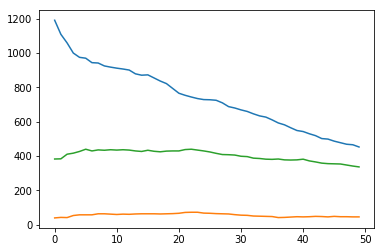

In [7]:
print(train_errors.shape)

for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(np.array(train_errors[i_rep, :]))
    plt.plot(np.array(validation_errors[i_rep, :]))
    plt.plot(np.array(test_errors[i_rep, :]))
    plt.show()

0


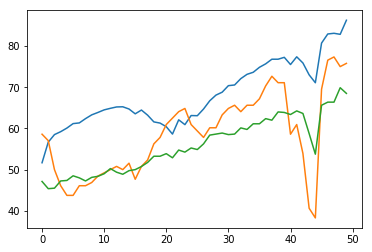

1


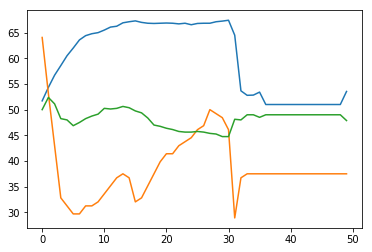

2


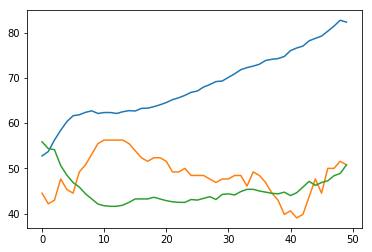

3


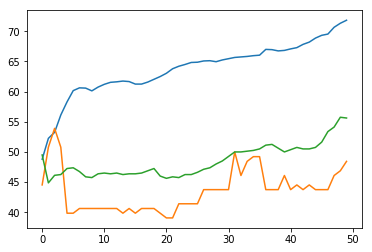

4


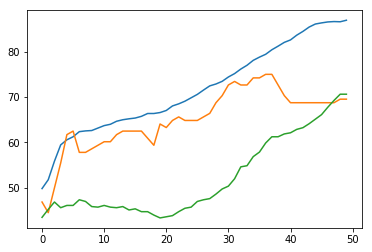

5


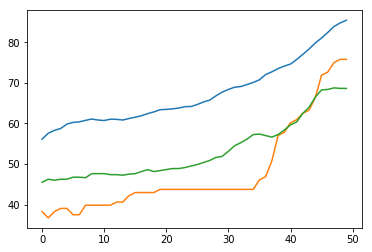

6


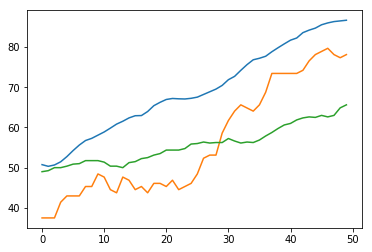

7


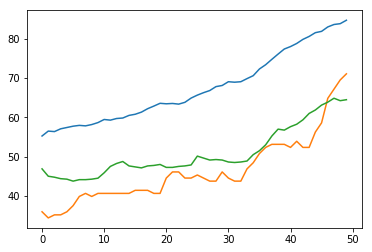

8


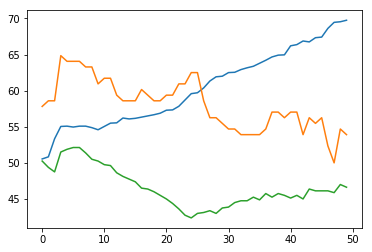

9


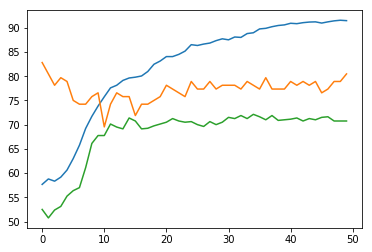

10


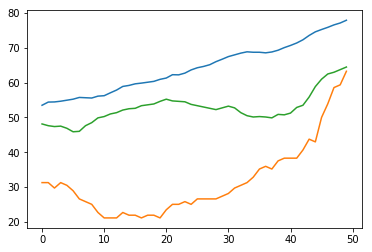

11


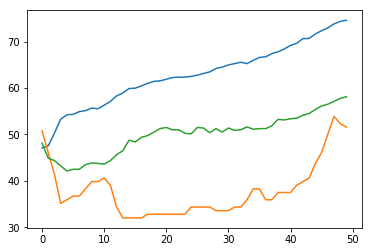

12


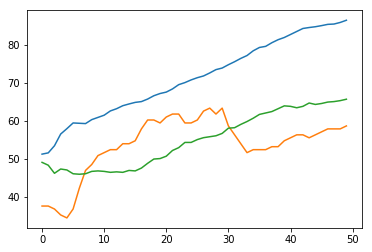

13


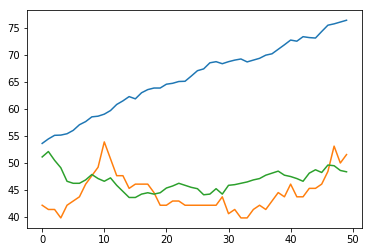

14


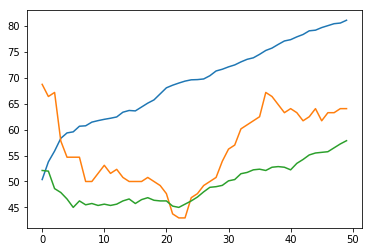

In [8]:
for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(100*(Ntrain-np.array(train_errors[i_rep, :]))/Ntrain)
    plt.plot(100*(Nvalidation-np.array(validation_errors[i_rep, :]))/Nvalidation)
    plt.plot(100*(Ntest-np.array(test_errors[i_rep, :]))/Ntest)

    plt.show()

(50,)
Training accuracy 79.7%+-9.233840942382812
Validation accuracy   62%+-12.466753005981445
Testing accuracy 60.3%+-8.372930526733398


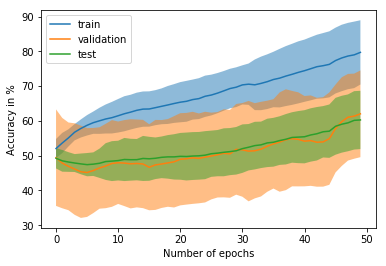

In [9]:
train_accuracy = 100*(Ntrain-np.array(train_errors))/Ntrain
val_accuracy = 100*(Nvalidation-np.array(validation_errors))/Nvalidation
test_accuracy = 100*(Ntest-np.array(test_errors))/Ntest

stddev_train_errors = np.std(train_accuracy, axis=0)
stddev_val_errors = np.std(val_accuracy, axis=0)
stddev_test_errors = np.std(test_accuracy, axis=0)

mean_train_errors = np.mean(train_accuracy, axis=0)
mean_val_errors = np.mean(val_accuracy, axis=0)
mean_test_errors = np.mean(test_accuracy, axis=0)

epoch = list(range(50))
print(stddev_train_errors.shape)

#plt.errorbar(epoch, mean_train_errors, stddev_train_errors)
#plt.errorbar(epoch, mean_val_errors, stddev_val_errors)
#plt.errorbar(epoch, mean_test_errors, stddev_test_errors)

plt.plot(epoch, mean_train_errors)
plt.plot(epoch, mean_val_errors)
plt.plot(epoch, mean_test_errors)
plt.fill_between(epoch, mean_train_errors+stddev_train_errors, mean_train_errors-stddev_train_errors, alpha=0.5)
plt.fill_between(epoch, mean_val_errors+stddev_val_errors, mean_val_errors-stddev_val_errors, alpha=0.5)
plt.fill_between(epoch, mean_test_errors+stddev_test_errors, mean_test_errors-stddev_test_errors, alpha=0.5)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy in %')
plt.legend(['train', 'validation', 'test'])

print("Training accuracy {:4.3g}%+-{}".format(mean_train_errors[-1], stddev_train_errors[-1]))
print("Validation accuracy {:4.3g}%+-{}".format(mean_val_errors[-1], stddev_val_errors[-1]))
print("Testing accuracy {:4.3g}%+-{}".format(mean_test_errors[-1], stddev_test_errors[-1]))